In [1]:
import os
import jsonlines

# 假设 OUTPUT_DIR 已经定义
OUTPUT_DIR = '.'

def read_specific_key_from_jsonl(key):
    # 构建文件路径
    file_path = os.path.join(OUTPUT_DIR, "params.jsonl")
    # 初始化一个列表来存储特定键的值
    values = []
    # 打开 JSONL 文件进行读取
    with jsonlines.open(file_path, mode='r') as reader:
        # 遍历文件中的每一行
        for obj in reader:
            # 检查当前对象是否包含指定的键
            if key in obj:
                # 如果包含，将该键的值添加到列表中
                values.append(obj[key])
    return values

# 示例：读取 'example_key' 键的值
# specific_key = 'example_key'
# result = read_specific_key_from_jsonl(specific_key)
# print(result)

import os
res_dir_root="/home/ckqsudo/code2024/CKQ_ACL2024/Control_Infer/SAE-simple/src/results/sentiment_analysis/sentiment_grid_analysis_2_8"
res_dir_list=os.listdir(res_dir_root)
print(len(res_dir_list))
res_dir_list=[i for i in res_dir_list if int(i.split("_")[-1])<=300]
assert len(res_dir_list)%12==0,"res_dir_list should be divided by 12"
from pathlib import Path
print(len(res_dir_list))

120
96


In [2]:
# del_end_of_sentence=1
# end_of_sentence="<|endoftext|>"
# metrics="ppl-small,dist-n,sentiment"
# sentiment_classifier_path='/home/ckqsudo/code2024/0models/sentiment-roberta-large-english'
# import logging
# logger = logging.getLogger(__name__)
# gpt2_path="/home/ckqsudo/code2024/0models/gpt-2-openai/gpt-2-openai"

In [3]:
# import pandas as pd
# from pathlib import Path
# import os
# import click
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# from eval_steer_utils import toxicity_score, sentiment_classify
# from eval_text_utils import conditional_perplexity, distinctness

In [4]:
import os
import jsonlines

# 假设 OUTPUT_DIR 已经定义
OUTPUT_DIR = '.'

def read_specific_key_from_jsonl(key):
    # 构建文件路径
    file_path = os.path.join(OUTPUT_DIR, "params.jsonl")
    # 初始化一个列表来存储特定键的值
    values = []
    # 打开 JSONL 文件进行读取
    with jsonlines.open(file_path, mode='r') as reader:
        # 遍历文件中的每一行
        for obj in reader:
            # 检查当前对象是否包含指定的键
            if key in obj:
                # 如果包含，将该键的值添加到列表中
                values.append(obj[key])
    return values

# 示例：读取 'example_key' 键的值
# specific_key = 'example_key'
# result = read_specific_key_from_jsonl(specific_key)
# print(result)

import os
res_dir_root="/home/ckqsudo/code2024/CKQ_ACL2024/Control_Infer/SAE-simple/src/results/sentiment_analysis/sentiment_grid_analysis_baseline/"
res_dir_list=os.listdir(res_dir_root)
print(len(res_dir_list))
from pathlib import Path
import copy 
from typing import final
import pandas as pd

import pandas as pd
from pathlib import Path
import os
import click
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from eval_steer_utils import toxicity_score, sentiment_classify
from eval_text_utils import conditional_perplexity, distinctness
del_end_of_sentence=1
end_of_sentence="<|endoftext|>"
metrics="ppl-small,dist-n,sentiment"
sentiment_classifier_path='/home/ckqsudo/code2024/0models/sentiment-roberta-large-english'
import logging
logger = logging.getLogger(__name__)
gpt2_path="/home/ckqsudo/code2024/0models/gpt-2-openai/gpt-2-openai"

files={"log":"execution.log","params":"params.jsonl","steer":"steer_gen_res.jsonl","no_steer":"no_steer_gen_res.jsonl"}
final_res=[]
for res_dir in res_dir_list:
    res_dir=Path(os.path.join(res_dir_root,res_dir))
    alpha_test_dir_list=os.listdir(res_dir)
    alpha_test_dir_list=[i for i in alpha_test_dir_list if i.startswith("alpha_203")]
    assert len(alpha_test_dir_list)==1,f"{res_dir}泽凯跑了{alpha_test_dir_list}"
    alpha_test_dir=Path(os.path.join(res_dir,alpha_test_dir_list[0]))
    param_file=os.path.join(alpha_test_dir,files["params"])
    with jsonlines.open(param_file, mode='r') as reader:
        for obj in reader:
            # 检查当前对象是否包含指定的键
            l,k,a=obj["layer"],obj["topk_cnt"],obj["alpha"]
            print(l,k,a)
    #################33
    no_steer_file=os.path.join(alpha_test_dir,files["no_steer"])
    print("记录原始结果 记录baseline的结果")
     
    if os.path.exists(no_steer_file):
        print("找到GPT原始生成的结果")
        gens_df = pd.read_json(no_steer_file, lines=True)
        if del_end_of_sentence == 1:
            print("delete "+end_of_sentence+" in generations")
            gens_df["generations"] = gens_df["generations"].apply(
            lambda gens: [
                {
                    "text": gen["text"].split(end_of_sentence)[1]
                    if gen["text"].startswith(end_of_sentence)
                    else gen["text"].split(end_of_sentence)[0]
                }
                for gen in gens
            ]
            )
        # raise ValueError(row)

        metricset = set(metrics.strip().lower().split(","))
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        ### calculate quality metrics
        # Fluency
        if 'sentiment' in metricset:
            print("sentiment") #c1
            sentiment_accuracy, sentiment_std = sentiment_classify(gens_df, sentiment_file=None, sentiment_classifier_path=sentiment_classifier_path)
        if "ppl-small" in metricset: #GPT2
            print("small")
            eval_model = AutoModelForCausalLM.from_pretrained(gpt2_path).to(device)
            eval_tokenizer = AutoTokenizer.from_pretrained(gpt2_path)
            torch.cuda.empty_cache()
            with torch.no_grad():
                ppl, total_ppl = conditional_perplexity(gens_df, eval_model, eval_tokenizer, device=device, write_file=None)
                
        if "dist-n" in metricset:
            dist1, dist2, dist3 = distinctness(gens_df)
            # write output results
        print()
        # l,k,a,sentiment_accuracy,sentiment_std,ppl, total_ppl, dist1, dist2, dist3
        res={"layer":l,"topk":k,"alpha":a,"senti_acc":sentiment_accuracy,"sent_str":sentiment_std,"ppl":ppl, "total_ppl": total_ppl, "dist1": dist1, "dist2": dist2, "dist3": dist3}
        print(res)
        final_res.append(copy.deepcopy(res))
#
import pandas as pd

# 假设 final_res 是一个包含多个字典的列表
# 例如：final_res = [{"layer": 0, "topk_cnt": 1, "alpha": 0.5, ...}, {...}, ...]

# 将 final_res 转换为 Pandas DataFrame
no_steer_df = pd.DataFrame(final_res)
res_dir="/home/ckqsudo/code2024/CKQ_ACL2024/Control_Infer/SAE-simple/src/evaluations/grid_eval"
no_steer_df.to_csv(os.path.join(res_dir,"final_no_steer_res.csv"), index=False)

1
0 1000 203.0
记录原始结果 记录baseline的结果
找到GPT原始生成的结果
delete <|endoftext|> in generations
sentiment


Device set to use cuda:0
Scoring generation sentiments: 100%|██████████| 500/500 [00:05<00:00, 96.85it/s] 


(500, 1)
mean of column 0 : 0.886
str of column0 :  0.317811264746862
small


Evaluating PPL: 100%|██████████| 500/500 [00:04<00:00, 101.63it/s]


6.586719823389714 500 500 500


Evaluating dist-n: 100%|██████████| 500/500 [00:00<00:00, 18247.21it/s]


{'layer': 0, 'topk': 1000, 'alpha': 203.0, 'senti_acc': 0.886, 'sent_str': 0.317811264746862, 'ppl': 6.586719823389714, 'total_ppl': 6.275249772997944, 'dist1': 0.8410252695915336, 'dist2': 0.9377075334048245, 'dist3': 0.931445291076913}


In [5]:
import pandas as pd
import os

# 假设 res_dir 是保存 CSV 文件的目录
# res_dir = "./your_result_directory"  # 请替换为实际的目录路径
res_dir="/home/ckqsudo/code2024/CKQ_ACL2024/Control_Infer/SAE-simple/src/evaluations/grid_eval"
# 构建要读取的 CSV 文件的完整路径
file_path = os.path.join(res_dir, "final_res.csv")

# 读取 CSV 文件
try:
    df_read = pd.read_csv(file_path)
    print("文件读取成功！")
    # 打印读取的 DataFrame 的基本信息
    df_read.info()
    # 打印 DataFrame 的前几行
    print(df_read.head())
except FileNotFoundError:
    print(f"未找到文件：{file_path}，请检查路径是否正确。")
except Exception as e:
    print(f"读取文件时出现错误：{e}")

文件读取成功！
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   layer      96 non-null     int64  
 1   topk       96 non-null     int64  
 2   alpha      96 non-null     float64
 3   senti_acc  96 non-null     float64
 4   sent_str   96 non-null     float64
 5   ppl        96 non-null     float64
 6   total_ppl  96 non-null     float64
 7   dist1      96 non-null     float64
 8   dist2      96 non-null     float64
 9   dist3      96 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 7.6 KB
   layer  topk  alpha  senti_acc  sent_str          ppl    total_ppl  \
0      2   150  203.0      0.202  0.401492    37.143998    24.287226   
1     10     5  203.0      0.874  0.331849     5.598633     5.355295   
2      1   300  203.0      0.238  0.425859  4026.640734  3852.724548   
3      3   150  203.0      0.686  0.464116    19.677715    16.394368   

In [6]:
# df=df_read
# df
no_steer_df.iloc[0]["ppl"]

6.586719823389714

In [7]:
no_steer_df

,layer,topk,alpha,senti_acc,sent_str,ppl,total_ppl,dist1,dist2,dist3
0,0,1000,203.0,0.886,0.317811,6.58672,6.27525,0.841025,0.937708,0.931445


In [8]:
df=df_read

/tmp/ipykernel_1834759/4219573436.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = heatmap_data.applymap(format_data)


topk        1         5          20          50          100          150  \
layer                                                                       
0      5.551420  5.598588  18.415021  227.920559  990.567227  1501.984537   
1      5.607829  5.601610   8.478379   12.269637  213.276349   314.180130   
2      5.542847  6.086993   7.999086   10.194013   12.825478    37.143998   
3      5.705496  6.111292   6.658309    9.859805   11.730866    19.677715   
4      5.551740  5.964375   6.481745    8.581202   11.458959    36.899561   
5      5.573558  5.641876   6.161231    8.201901   43.993058    84.782065   
6      5.610330  5.616176   6.404729    8.676217   11.786668    15.066382   
7      5.699068  6.119800   6.425653    9.364443    9.962275    10.916500   
8      5.612118  5.741159   5.834977    7.425387    9.502456    10.815061   
9      5.602082  5.573197   5.876760    7.326091    7.679098     8.535813   
10     5.562400  5.598633   5.768585    6.917439    7.386520     7.810750   

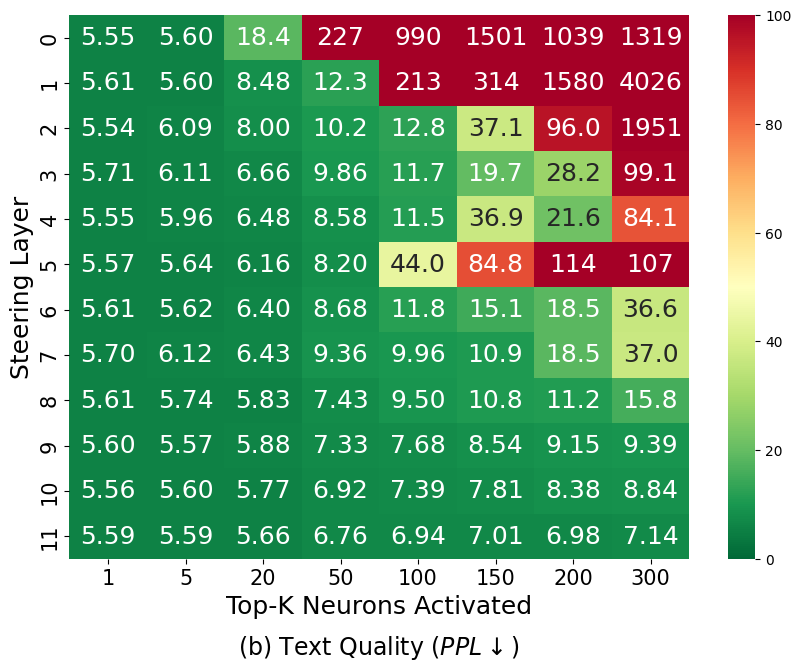

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# plt.rcParams['font.family'] = 'Times New Roman'
# df = pd.DataFrame(data)

# 1. 根据 layer 和 topk 列对数据进行排序
df = df.sort_values(by=['layer', 'topk'])

# 2. 对 senti_acc 列进行归一化处理
# scaler = MinMaxScaler()
# df['ppl_norm'] = scaler.fit_transform(df[['ppl']])
df[['ppl_show']] = df[['ppl']].apply(lambda x: x)

# 3. 将数据转换为适合绘制热力图的二维格式
heatmap_data = df.pivot(index='layer', columns='topk', values='ppl_show')

# 4. 格式化数据，<10保留一位小数，>=10保留整数
def format_data(val):
    if val < 10:
        return f'{val:.2f}'
    elif 10 < val < 100:
        return f'{val:.1f}'
    else:
        return f'{int(val)}'

formatted_data = heatmap_data.applymap(format_data)

print(heatmap_data) 

# 5. 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=formatted_data, fmt='', cmap='RdYlGn_r', vmin=0, vmax=100,
            annot_kws={'size': 18})  # 统一数字颜色为黑色
plt.title(r'(b) Text Quality ($PPL \downarrow$)', fontsize=17, y=-0.19, ha='center')  # 设置标题下移并居中

plt.xlabel('Top-K Neurons Activated', fontsize=18)
plt.ylabel('Steering Layer', fontsize=18)

# 调整坐标轴上的数字字体大小
plt.tick_params(axis='both', labelsize=15)

# 增加空白区域来避免标题与坐标轴重叠
plt.subplots_adjust(bottom=0.2)  # 调整图形底部的空白区域大小

# 显示热力图
plt.show()


In [10]:
no_steer_df

,layer,topk,alpha,senti_acc,sent_str,ppl,total_ppl,dist1,dist2,dist3
0,0,1000,203.0,0.886,0.317811,6.58672,6.27525,0.841025,0.937708,0.931445


In [11]:
no_steer_df.iloc[0]["senti_acc"]

0.886

In [12]:
no_steer_df

,layer,topk,alpha,senti_acc,sent_str,ppl,total_ppl,dist1,dist2,dist3
0,0,1000,203.0,0.886,0.317811,6.58672,6.27525,0.841025,0.937708,0.931445


In [13]:
no_steer_df.iloc[0]["senti_acc"]

0.886

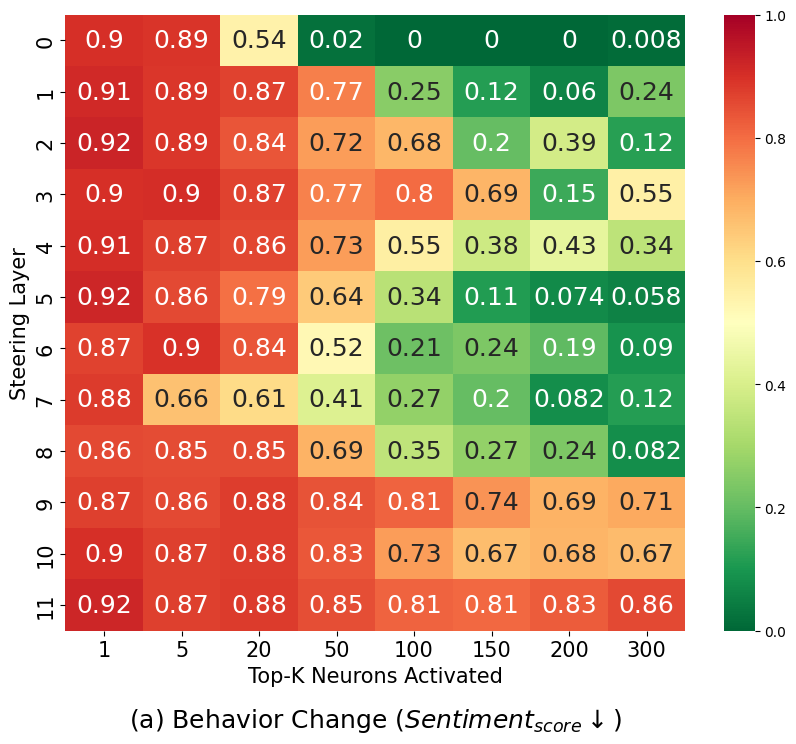

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# df = pd.DataFrame(data)

# 1. 根据 layer 和 topk 列对数据进行排序
df = df.sort_values(by=['layer', 'topk'])

# 2. 对 senti_acc 列进行归一化处理
# scaler = MinMaxScaler()
# df['senti_acc_normalized'] = scaler.fit_transform(df[['senti_acc']])

# 3. 将数据转换为适合绘制热力图的二维格式
df[['senti_acc_show']] = df[['senti_acc']].apply(lambda x: x)

heatmap_data = df.pivot(index='layer', columns='topk', values='senti_acc_show')

# 4. 格式化数据，<10保留一位小数，>=10保留整数
def format_data(val):
    if 0 < val < 1:
        return f'{val:.2f}'
    else:
        return f'{int(val)}'

formatted_data = heatmap_data.applymap(format_data)

# 5. 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', vmin=0, vmax=1, annot_kws={'size': 18})
sns.heatmap(heatmap_data, annot=formatted_data, fmt='', cmap='RdYlGn_r', vmin=0, vmax=1, annot_kws={'size': 18})  # 统一数字颜色为黑色
plt.title(r'(a) Behavior Change ($Sentiment_{score} \downarrow$)', fontsize=18, y=-0.17, ha='center')  # 设置标题下移并居中

plt.xlabel('Top-K Neurons Activated', fontsize=15)
plt.ylabel('Steering Layer', fontsize=15)

# 调整坐标轴上的数字字体大小
plt.tick_params(axis='both', labelsize=15)

# 显示热力图
plt.show()
